# Random Forest

more than one decision tree individually learns data and then vote!

bootstrapping: separating data sets but they can have nesting

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby("column_name").cumcount(),
                                  columns=["dup_cnt"])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how="outer")
    new_feature_name_df["column_name"] = new_feature_name_df[["column_name", "dup_cnt"]] \
        .apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(["index"], axis=1)
    return new_feature_name_df

In [4]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv("../human_activity/features.txt", sep="\s+",
                                  header=None, names=["column_index", "column_name"])

    # calls get_new_feature_name_df
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv("../human_activity/train/X_train.txt", sep="\s+", names=feature_name)
    X_test = pd.read_csv("../human_activity/test/X_test.txt", sep="\s+", names=feature_name)

    y_train = pd.read_csv("../human_activity/train/y_train.txt", sep="\s+", header=None,  names=["action"])
    y_test = pd.read_csv("../human_activity/test/y_test.txt", sep="\s+", header=None, names=["action"])

    return X_train, X_test, y_train, y_test

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = get_human_dataset()

# Random Forest
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
prd = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, prd)
print("RandomForest accuracy: {0:.4f}".format(accuracy))

RandomForest accuracy: 0.9196


## Random Forest hyper parameter

- n_estimators: tree amounts
- max_features: sqrt of features
- max_depth, min_samples_leaf, min_samples_split

In [7]:
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

params = {
    "max_depth": [8, 16, 24],
    "min_samples_leaf": [1, 6, 12],
    "min_samples_split": [2, 8, 16],
}

# GridSearchCV
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=1)
grid_cv.fit(X_train, y_train)

print("best hyper parameter:", grid_cv.best_params_)
print("best estimated accuracy:", grid_cv.best_score_)

end_time = time.time()

print("elapsed time: {0:.3f}".format(end_time - start_time))

best hyper parameter: {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
best estimated accuracy: 0.9164853101196953
elapsed time: 33.203


In [8]:
# learning using best parameters
rf_clf_best = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                     min_samples_split=2, random_state=0)
rf_clf_best.fit(X_train, y_train)
prd = rf_clf_best.predict(X_test)
print("accuracy: {0:.4f}".format(accuracy_score(y_test, prd)))

accuracy: 0.9260


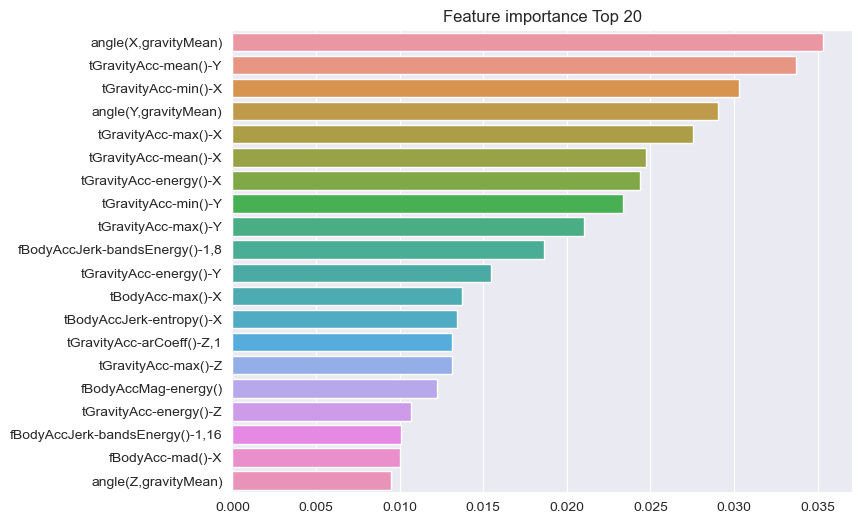

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importance_values = rf_clf_best.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title("Feature importance Top 20")
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()